### Задача о течении в канале

Рассматривается задача о развитом течении в канале (Plane Poiseuille flow), см. [1].

Границы канала - $y = -1$ и $y = 1$. Ось канала $y = 0$. Канал плоский.

1. Khorrami, M. R., & Malik, M. R. (1993). Efficient computation of spatial eigenvalues for hydrodynamic stability analysis. Journal of Computational Physics, 104(1), 267-272.

In [1]:
# Plane poiseuille flow profile
def get_U(y):
    return 1 - y**2

def get_dudy(y):
    return -2*y

#### Сформируем матрицы для решения задачи на собственные значения на собственные значения

Поскольку задача здесь рассматривается во временной постановке, то рассматриваем задачу $A\phi = \omega B \phi$. Матрицы $A$ и $B$ получаются после аппроксимации краевой задачи $E_1\phi_yy + E_2\phi_y + E_3\phi = \omega E_4\phi$. Необходимо на основании уравнений 8-10 из статьи [1] выписать матрицы $E_2$ и $E_3$ (реализовать метод getE2 и getE3). Матрицы  $E_1$ и $E_4$ уже выписаны. Далее необходимо сформировать матрицу $A$ (метод getA_matrix). Метод для формирования матрицы $B$ уже реализован (getB_matrix).

In [6]:
from scipy.sparse import block_diag
import numpy as np

def getE1(Re):
    return np.array([[1/Re, 0, 0],
                     [0, 1/Re, 0],
                     [0, 0, 0]])

def getE2():
    return np.array([[0, 0, 0], [0, 0, -1], [0, 1, 0]])


def getE3(alpha, Re, u, dudy):
    return np.array([[-1j * u * alpha - alpha**2 / Re, -dudy, -1j * alpha],
                     [0, -1j * alpha * u - alpha**2 / Re, 0], [1j * alpha, 0, 0]])

# artificial compressibility added (gamma). See: 
# Khorrami, M. R., Malik, M. R., & Ash, R. L. (1989). Application of spectral collocation techniques
# to the stability of swirling flows. Journal of Computational Physics, 81(1), 206-229.
def getE4():
    gamma = 0.0001
    return np.array([[-1j, 0, 0],
                       [0, -1j, 0],
                       [0, 0, -gamma]])

def get_y(j, h):
    return -1 + h*j

def getA_matrix(alpha, Re, N, comp_num = 3):
    h = 2 / (N - 1)
    matrix_list = list()
    
    # Form first line of matrix A
    line = list()
    y = get_y(1, h)
    u = get_U(y)
    dudy = get_dudy(y)
    E1 = getE1(Re)
    E2 = getE2()
    E3 = getE3(alpha, Re, u, dudy)

    L2 = E3 - 2. / h ** 2 * E1
    line.append(L2)
    L3 = 1. / h ** 2 * E1 + 1. / (2 * h) * E2
    line.append(L3)
    for i in range(3,N):
        line.append(np.zeros((comp_num,comp_num)))
    matrix_list.append(line)

    # Form inner lines of matrix A
    for i in range(2, N-1):
        line = list()
        y = get_y(i, h)
        u = get_U(y)
        dudy = get_dudy(y)
        E1 = getE1(Re)
        E2 = getE2()
        E3 = getE3(alpha, Re, u, dudy)
        #E4 = getE4()
        for j in range(1, N):
            if j==i-1:
                L1 = 1. / h ** 2 * E1 - 1. /(2 * h) * E2
                line.append(L1)
            elif j==i:
                L2 = E3 - 2. / h ** 2 * E1
                line.append(L2)
            elif j==i+1:
                L3 = 1. / h ** 2 * E1 + 1. /(2 * h) * E2
                line.append(L3)
            else:
                line.append(np.zeros((comp_num,comp_num)))
        matrix_list.append(line)

    # Form last line of matrix A
    line = list()
    for i in range(1, N-2):
        line.append(np.zeros((comp_num,comp_num)))
    
    y = get_y(N-1, h)
    u = get_U(y)
    dudy = get_dudy(y)
    E1 = getE1(Re)
    E2 = getE2()
    E3 = getE3(alpha, Re, u, dudy)
    #E4 = getE4()
    L1 = 1. / h ** 2 * E1 - 1. /( 2 * h ) * E2
    line.append(L1)
    L2 = E3 - 2. / h ** 2 * E1 
    line.append(L2)
    matrix_list.append(line)

    return np.bmat(matrix_list)

def getB_matrix(alpha, Re, N, comp_num = 3):
    h = 2 / (N - 1) 
    print('h = ', h)
    matrix_list = list()
    for i in range(1,N):
        E4 = getE4()
        matrix_list.append(E4)
    return block_diag(matrix_list).toarray()

Теперь решим задачу о поиске неустойчивых мод для течения в канале c числом Рейнольдса $Re = 10000$ для возмущений с волновым числом $\alpha$. Сначала задаем число узлов в сетке для решения одномерной задачи $N$ и формируем матрицы $A$ и $B$.

In [7]:
# Test case
import sympy as sp
N = 400
# test 1
alpha = 1
Re = 10000
A = getA_matrix(alpha, Re, N)
B = getB_matrix(alpha, Re, N)

h =  0.005012531328320802


Решаем задачу на собственные значения

In [8]:
import scipy.linalg as la
eigvals = la.eigvals(A, B)
eigvals = eigvals/alpha # на графике частоты делят на alpha

Строим график для для всех мод 

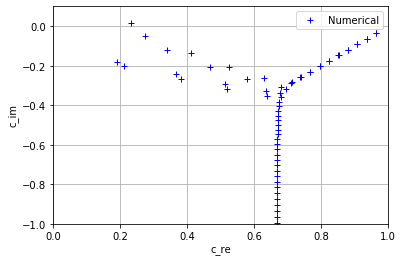

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(eigvals.real, eigvals.imag, '+b', label='Numerical')
plt.legend()
# test 1
plt.xlim(0, 1)
plt.ylim(-1, 0.1)
plt.grid() 
plt.xlabel('c_re')
plt.ylabel('c_im')
plt.savefig('Temporal spectrum.png', dpi=200)

Присутствуют ли на графике физичные неустойчивые моды? Если да, укажите $\omega$.

In [12]:
for i in range(eigvals.real.size):
    if eigvals.real[i] > 0 and eigvals.imag[i] > 0:
        print(f"Физически неустойчивая мода: w = {eigvals[i]}")

Физически неустойчивая мода: w = (0.23162727835836006+0.014982698395876896j)
